$$\textbf{Projekt z Fizyki Kwantowej}$$

$$\text{Rozwiązanie jednowymiarowego równania Schrödingera}$$

$$\text{Martyna Marszałek, Marcin Pąśko}$$

# Jednowymiarowe Równanie Schrödingera

$$ 
i \hbar \frac{\partial}{\partial t} \psi(x,t) = -\frac{\hbar^2}{2m}\frac{\partial^2}{\partial x^2}\psi(x,t) + V(x) \psi(x,t) 
$$

$$
\psi(0, t) = \psi(L,t)=0  
$$

$$ \textbf{Stosujemy konwencję } \hbar\textbf{ = 1} $$
Korzystamy z metody Cranka - Nicholsona, równanie Schrödingera przyjmuje wówczas postać:

$$
i \hbar \frac{\psi_{j}^{m+1} - \psi_{j}^{m}}{\Delta t} = - \frac{\hbar^2}{2m}\frac{\psi_{j+1}^{m} -2\psi_j^m + \psi_{j-1}^{m}}{\Delta x^2} +V(x)\psi_j^m
$$

$$
\psi_{j}^{m+1} - \psi_{j}^{m} = \frac{i \hbar}{2m} \frac{\Delta t}{\Delta x^2} (\psi_{j+1}^{m} -2\psi_j^m + \psi_{j-1}^{m})-\frac{i}{\hbar}\Delta t V(x) \psi_j^m
$$

In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter
import numba
from numba import jit
from scipy.linalg import eigh_tridiagonal
from IPython.display import HTML
from scipy import sparse
from scipy import integrate

In [2]:
Nx = 400                                    # liczba punktów oś x
Nt = 100000                                 # liczba punktów czas
dx = 1/(Nx-1)                               # interwał x
dt = 1e-7                                   # interwał czasu
a = 1                                       # szerokość studni liczona od x=0
x = np.linspace(0, 1, Nx)                   # inicjalizacja osi x
psi0 = np.sqrt(2/a)*np.sin(np.pi*x/a)       # psi 0

m = 0.5
hbar = 1

# $$ \text{Przykład 1: Potencjał z rozkładu normalnego} $$

Text(0, 0.5, '$V(x)$')

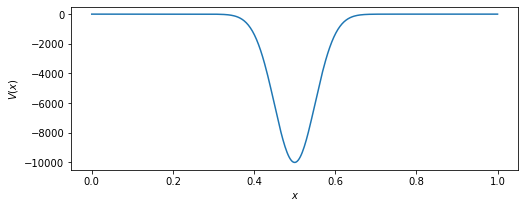

In [3]:
mu, sigma = 1/2, 1/20                        # parametry funkcji Gaussa
V = -10000*np.exp(-(x-mu)**2/(2*sigma**2))   # potencjał - funkcja Gaussa (rozkład normalny)

plt.figure(figsize=(8,3))
plt.plot(x,V)
plt.xlabel('$x$')
plt.ylabel('$V(x)$')

In [4]:
psi = np.zeros([Nt,Nx])
psi[0] = psi0

In [5]:
@numba.jit("c16[:,:](c16[:,:])", nopython=True, nogil=True)
def oblicz_psi(psi):
    for t in range(0, Nt-1):
        for i in range(1, Nx-1):
            psi[t+1][i] = psi[t][i] + 1j*hbar/(2*m) * dt/dx**2 * (psi[t][i+1] - 2*psi[t][i] + psi[t][i-1]) - 1j /hbar *dt*V[i]*psi[t][i]
        
        #aby zapewnic normalizację na bieżąco
        normalizacja = np.sum(np.absolute(psi[t+1])**2)*dx
        for i in range(1, Nx-1):
            psi[t+1][i] = psi[t+1][i]/normalizacja
        
    return psi

In [6]:
psi_m1 = oblicz_psi(psi.astype(complex))

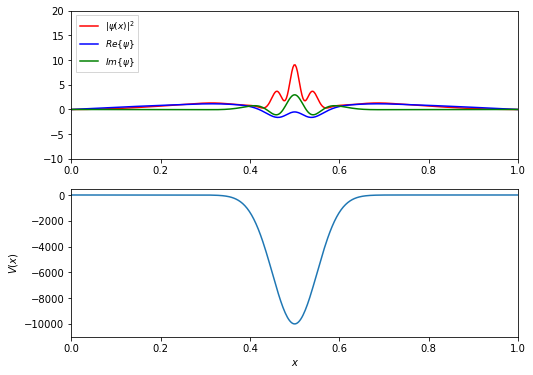

In [7]:
def animate(i):
    ln1.set_data(x, np.absolute(psi_m1[10*i])**2)
    ln2.set_data(x, np.real(psi_m1[10*i]))
    ln3.set_data(x, np.imag(psi_m1[10*i]))
    
fig = plt.figure(figsize=(8, 6))
ax1 = plt.subplot(2, 1, 1)

ln1, = plt.plot([], [], 'r', markersize=8, label="$|\psi(x)|^2$")
ln2, = plt.plot([], [], 'b', markersize=8, label="$Re\{ \psi \}$")
ln3, = plt.plot([], [], 'g', markersize=8, label="$Im\{ \psi \}$")

ax1.set_ylim(-10, 20)
ax1.set_xlim(0,1)
plt.legend(loc=2, fontsize=9, fancybox=False)

ax2 = plt.subplot(2, 1, 2)
ax2.set_ylim(-11000, 500)
ax2.set_xlim(0,1)
plt.plot(x,V)
plt.xlabel('$x$')
plt.ylabel('$V(x)$')

ani = animation.FuncAnimation(fig, animate, frames=1000, interval=50)

ani.save('potencjał_gaussowski_projekt.mp4', fps=15, extra_args=['-vcodec', 'libx264'], dpi=300)

# $$ \text{Przykład 2: Bariera potencjału - inny zapis } $$

$$ 
\frac{\partial^2}{\partial x^2}\psi(x) = \frac{\psi_{j+1}^{m} -2\psi_j^m + \psi_{j-1}^{m}}{(dx)^2} = 
%
\frac{1}{(dx)^2} \left[\begin{array}{ccccccc}
-2&1&0&0&0&...&0\\
1&-2&1&0&0&...&0\\
0&1&-2&1&0&...&0\\
...&...&...&...&...&...&...\\
0&...&0&0&0&1&-2
\end{array}\right] \cdot 
\left[\begin{array}{c}
\psi_1\\
\psi_2\\
\psi_3\\
...\\
\psi_n
\end{array}\right] = D2 \cdot \psi$$

# $${\color{green} {Funkcja}}$$ $${\color{green} { falowa}}$$


Rozważamy funkcję falową pochodzącą z rozkładu Gaussa o parametrach $ \mu $  i  $ \sigma $:

$$ \psi (x,0) = A \cdot exp\left( \frac{-(x-\mu)^2}{2 \sigma^2} \right) $$

gdzie A - stała normalizacyjna - wyznaczamy z warunku normalizacji:

$$ | \psi(x,0) |^2 = A^2 \cdot exp \left( \frac{(x-\mu)^2}{\sigma^2} \right) $$

$$ \int_{\infty}^{\infty} | \psi(x,0) |^2 dx = A^2 \sigma \sqrt{\pi} = 1 $$

Stąd:

$$ A^2 = \frac{1}{\sigma \sqrt{\pi}} \implies A = \sqrt{\frac{1}{\sigma \sqrt{\pi}}} $$

In [67]:
# Warunki początkowe
dx = 0.005                  # interwał x
x = np.arange(0, 10, dx)    # oś x
kx = 50                     # liczba falowa 
m = 1                       # masa
sigma = 0.5                 # parametr rozkładu normalnego
mu = 3.0                    # parametr rozkładu normalnego

# Inicjalizacja funkcji falowej - rozkład Gaussa 
A = 1.0 / (sigma * np.sqrt(np.pi))  # stała normalizacyjna to jest A^2
psi0 = np.sqrt(A) * np.exp(-(x-mu)**2 / (2.0 * sigma**2)) * np.exp(1j * kx * x)

V = np.zeros(x.shape)
for i, _x in enumerate(x):
    if _x > 5:
        V[i] = 1000
        
V[0] = 10000
V[len(x) - 1] = -10000

print("Prawdopodobieństwo całkowite: ", np.round(np.sum(np.abs(psi0)**2)*dx))

# generowanie macierzy rzadkiej
D2 = sparse.diags([1, -2, 1], [-1, 0, 1], shape=(x.size, x.size)) / dx**2

hbar = 1

def psi_t(t, psi):
    return -1j * (- 0.5 * hbar / m * D2.dot(psi) + V / hbar * psi)

# Rozwiązywanie
dt = 0.001                      # interwał
t0 = 0.0                        # czas zerowy
tf = 0.15                       # czas końcowy
t_eval = np.arange(t0, tf, dt)  # czas trwania

print("Trwa rozwiązywanie")
sol = integrate.solve_ivp(psi_t,
                          t_span=[t0, tf],
                          y0=psi0,
                          t_eval=t_eval)

print("Rozwiązywanie zakończone")

Prawdopodobieństwo całkowite:  1.0
Trwa rozwiązywanie
Rozwiązywanie zakończone


Generowanie mp4


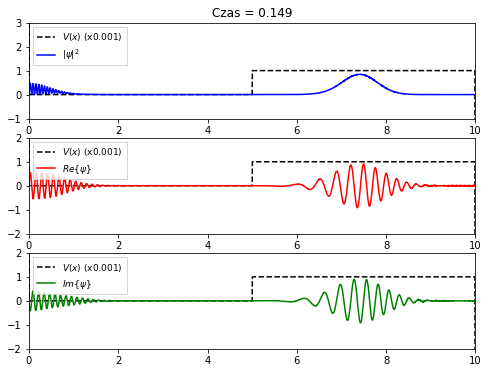

In [68]:
fig = plt.figure(figsize=(8, 6))

ax1 = plt.subplot(3, 1, 1)
ax1.set_xlim(0, 10)
ax1.set_ylim(-1, 3)
title = ax1.set_title('')
line11, = ax1.plot([], [], "k--", label=r"$V(x)$ (x0.001)")
line12, = ax1.plot([], [], "b", label=r"$\vert \psi \vert^2$")
plt.legend(loc=2, fontsize=9, fancybox=False)

ax2 = plt.subplot(3, 1, 2)
ax2.set_xlim(0, 10)
ax2.set_ylim(-2, 2)
line21, = ax2.plot([], [], "k--", label=r"$V(x)$ (x0.001)")
line22, = ax2.plot([], [], "r", label=r"$Re\{ \psi \}$")
plt.legend(loc=2, fontsize=9, fancybox=False)


ax3 = plt.subplot(3, 1, 3)
ax3.set_xlim(0, 10)
ax3.set_ylim(-2, 2)
line31, = ax3.plot([], [], "k--", label=r"$V(x)$ (x0.001)")
line32, = ax3.plot([], [], "g", label=r"$Im\{ \psi \}$")
plt.legend(loc=2, fontsize=9, fancybox=False)

def init():
    line11.set_data(x, V * 0.001)
    line21.set_data(x, V * 0.001)
    line31.set_data(x, V * 0.001)
    return line11, line21, line31


def animate(i):
    line12.set_data(x, np.abs(sol.y[:, i])**2)
    line22.set_data(x, np.real(sol.y[:, i]))
    line32.set_data(x, np.imag(sol.y[:, i]))
    title.set_text('Czas = {0:1.3f}'.format(sol.t[i]))
    return line12, line22, line32


anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(sol.t), interval=200, blit=True)

# Zapisywanie do pliku mp4
print("Generowanie mp4")
anim.save('schodek_gauss_ok.mp4', fps=15, extra_args=['-vcodec', 'libx264'], dpi=300)

# $$\text{Przykład 3 - potencjał prostokątny}$$

$$
V(x)=\begin{cases}
			-10000, & \text{x} \in \text{(4.5;5.5)}\\
            0, & \text{wpp}
		 \end{cases}
$$

Text(0, 0.5, '$V(x)$')

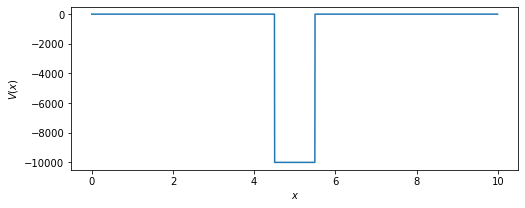

In [70]:
V = np.zeros(x.shape)
for i, _x in enumerate(x):
    if _x > 4.5 and _x < 5.5:
        V[i] = -10000
        
plt.figure(figsize=(8,3))
plt.plot(x,V)
plt.xlabel('$x$')
plt.ylabel('$V(x)$')

Prawdopodobieństwo całkowite:  1.0
Trwa rozwiązywanie
Rozwiązywanie zakończone
Generowanie mp4


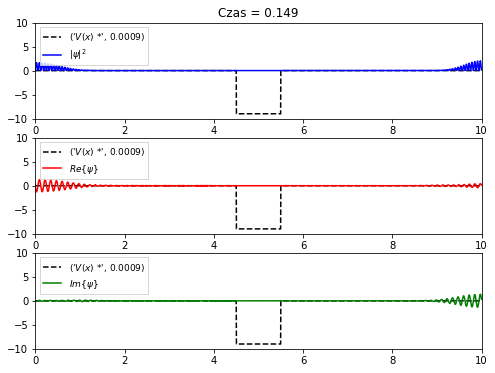

In [71]:
dx = 0.005                  # interwał x
x = np.arange(0, 10, dx)    # oś x

V = np.zeros(x.shape)
for i, _x in enumerate(x):
    if _x > 4.5 and _x < 5.5:
        V[i] = -10000
        
potencjal2 = potencjal(0, 10, 50, 1, 0.5, 2, 0.0, 0.15, 0.0009, V, 'potencjal_prostokatny.mp4')
#(x-start, x-end, kx, masa, sigma, mu, t0, tf, mnoznik, V, name)

# Kolejne przykłady 

In [32]:
def potencjal(a, b, kx, m, sigma, mu, t0, tf, mn, V, name):
    
    #mn - mnożnik do potencjału 
    
    # Warunki początkowe
    
    dx = 0.005                 # interwał x
    x = np.arange(a, b, dx)    # oś x
    
    #kx = 50                     # liczba falowa 
    #m = 1                       # masa
    #sigma = 0.5                 # parametr rozkładu normalnego
    #mu = 3.0                    # parametr rozkładu normalnego

    # Inicjalizacja funkcji falowej - rozkład Gaussa 
    A = 1.0 / (sigma * np.sqrt(np.pi))  # stała normalizacyjna to jest A^2
    psi0 = np.sqrt(A) * np.exp(-(x-mu)**2 / (2.0 * sigma**2)) * np.exp(1j * kx * x)

    # Potencjał V(x)
    
    dt = 0.001  # interwał czasowy
    t_eval = np.arange(t0, tf, dt)  # czas trwania

    print("Prawdopodobieństwo całkowite: ", np.round(np.sum(np.abs(psi0)**2)*dx))

    D2 = sparse.diags([1, -2, 1], [-1, 0, 1], shape=(x.size, x.size)) / dx**2
    hbar = 1

    def psi_t(t, psi):
        return -1j * (- 0.5 * hbar / m * D2.dot(psi) + V / hbar * psi)
    
    print("Trwa rozwiązywanie")
    sol = integrate.solve_ivp(psi_t,
                              t_span=[t0, tf],
                              y0=psi0,
                              t_eval=t_eval)

    print("Rozwiązywanie zakończone")
    
    fig = plt.figure(figsize=(8, 6))

    ax1 = plt.subplot(3, 1, 1)
    ax1.set_xlim(a, b)
    ax1.set_ylim(-10, 10)
    title = ax1.set_title('')
    line11, = ax1.plot([], [], "k--", label=(r'$V(x)$ *', mn))
    line12, = ax1.plot([], [], "b", label=r"$\vert \psi \vert^2$")
    plt.legend(loc=2, fontsize=9, fancybox=False)

    ax2 = plt.subplot(3, 1, 2)
    ax2.set_xlim(a, b)
    ax2.set_ylim(-10, 10)
    line21, = ax2.plot([], [], "k--", label=(r'$V(x)$ *', mn))
    line22, = ax2.plot([], [], "r", label=r"$Re\{ \psi \}$")
    plt.legend(loc=2, fontsize=9, fancybox=False)


    ax3 = plt.subplot(3, 1, 3)
    ax3.set_xlim(a, b)
    ax3.set_ylim(-10, 10)
    line31, = ax3.plot([], [], "k--", label=(r'$V(x)$ *', mn))
    line32, = ax3.plot([], [], "g", label=r"$Im\{ \psi \}$")
    plt.legend(loc=2, fontsize=9, fancybox=False)

    def init():
        line11.set_data(x, V * mn)
        line21.set_data(x, V * mn)
        line31.set_data(x, V * mn)
        return line11, line21, line31


    def animate(i):
        line12.set_data(x, np.abs(sol.y[:, i])**2)
        line22.set_data(x, np.real(sol.y[:, i]))
        line32.set_data(x, np.imag(sol.y[:, i]))
        title.set_text('Czas = {0:1.3f}'.format(sol.t[i]))
        return line12, line22, line32


    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(sol.t), interval=200, blit=True)

    # Zapisywanie do pliku mp4
    print("Generowanie mp4")
    anim.save(name, fps=15, extra_args=['-vcodec', 'libx264'], dpi=300)
    return anim

# 

# $$\text{Kolejne przykłady - Przykład 1}$$

$$
V(x)=\begin{cases}
			1000, & \text{x} \in \text{(4.7;5.3)}\\
            0, & \text{wpp}
		 \end{cases}
$$


Prawdopodobieństwo całkowite:  1.0
Trwa rozwiązywanie
Rozwiązywanie zakończone
Generowanie mp4


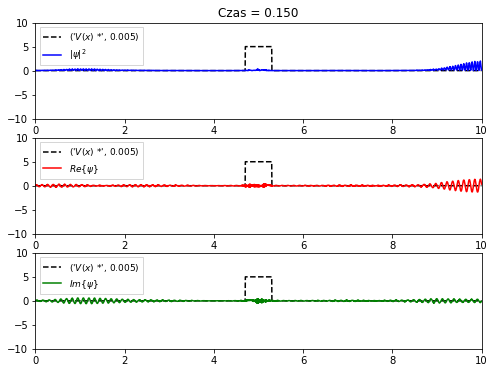

In [36]:
dx = 0.005                  # interwał x
x = np.arange(0, 10, dx)    # oś x

V = np.zeros(x.shape)
for i, _x in enumerate(x):
    if _x > 4.7 and _x < 5.3:
        V[i] = 1000        
        
potencjal(0, 10, 50, 1, 0.5, 3.0, 0.0, 0.151, 0.005, V, 'przyklad_1.mp4')
#(x-start, x-end, kx, masa, sigma, mu, t0, tf, mnoznik, V, name)

# 

# $$\text{Kolejne przykłady - Przykład 2}$$

$$
V(x)=\begin{cases}
			2000, & \text{x} \in \text{(-0.5;0.5)}\\
            0, & \text{wpp}
		 \end{cases}
$$


Prawdopodobieństwo całkowite:  1.0
Trwa rozwiązywanie
Rozwiązywanie zakończone
Generowanie mp4


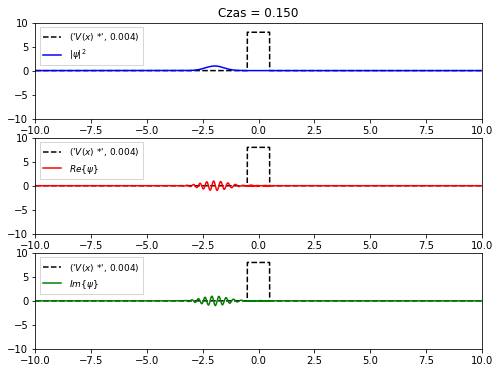

In [38]:
dx = 0.005                    # interwał x
x = np.arange(-10, 10, dx)    # oś x

V = np.zeros(x.shape)
for i, _x in enumerate(x):
    if _x > -0.5 and _x < 0.5:
        V[i] = 2000
        
potencjal2 = potencjal(-10, 10, 20, 1, 0.5, -2, 0.0, 0.151, 0.004, V, 'przyklad_2.mp4')
#(x-start, x-end, kx, masa, sigma, mu, t0, tf, mnoznik, V, name)

# $$\text{Kolejne przykłady - Przykład 3}$$

$$
V(x)=\begin{cases}
			950, & \text{x} \in \text{(-0.5;0.5)}\\
            -900, & \text{wpp}
		 \end{cases}
$$


Prawdopodobieństwo całkowite:  1.0
Trwa rozwiązywanie
Rozwiązywanie zakończone
Generowanie mp4


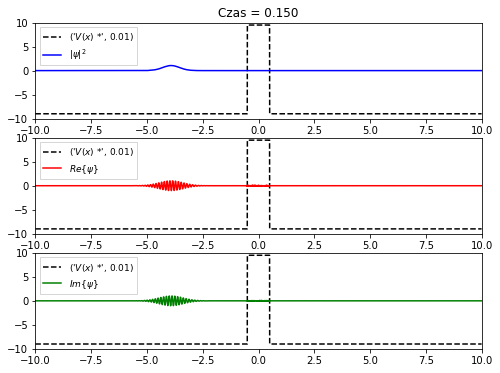

In [39]:
dx = 0.005                    # interwał x
x = np.arange(-10, 10, dx)    # oś x

V = np.zeros(x.shape) - 900
for i, _x in enumerate(x):
    if _x > -0.5 and _x < 0.5:
        V[i] = 950
        
potencjal2 = potencjal(-10, 10, 50, 1.5, 0.5, -2, 0.0, 0.151, 0.01, V, 'przyklad_3.mp4')
#(x-start, x-end, kx, masa, sigma, mu, t0, tf, mnoznik, V, name)

# $$\text{Kolejne przykłady - Przykład 4}$$

$$
V(x)=\begin{cases}
			-1000, & \text{x} \in \text{(-0.5;0.5)}\\
            500, & \text{wpp}
		 \end{cases}
$$


Prawdopodobieństwo całkowite:  1.0
Trwa rozwiązywanie
Rozwiązywanie zakończone
Generowanie mp4


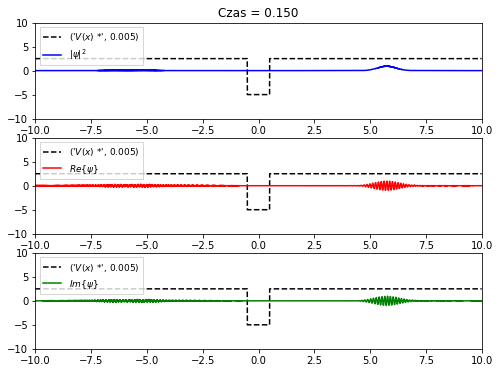

In [53]:
dx = 0.005                    # interwał x
x = np.arange(-10, 10, dx)    # oś x

V = np.zeros(x.shape)+500
for i, _x in enumerate(x):
    if _x > -0.5 and _x < 0.5:
        V[i] = -1000
        
potencjal2 = potencjal(-10, 10, 50, 1, 0.5, -2, 0.0, 0.151, 0.005, V, 'przyklad_4.mp4')
#(x-start, x-end, kx, masa, sigma, mu, t0, tf, mnoznik, V, name)

# $$\text{Kolejne przykłady - Przykład 5}$$

$$
V(x)=\begin{cases}
			900, & \text{x} \in \text{(-2;-1.5)}\\
            900, & \text{x} \in \text{(1;1.5)}\\
            -500, & \text{wpp}
		 \end{cases}
$$


Prawdopodobieństwo całkowite:  1.0
Trwa rozwiązywanie
Rozwiązywanie zakończone
Generowanie mp4


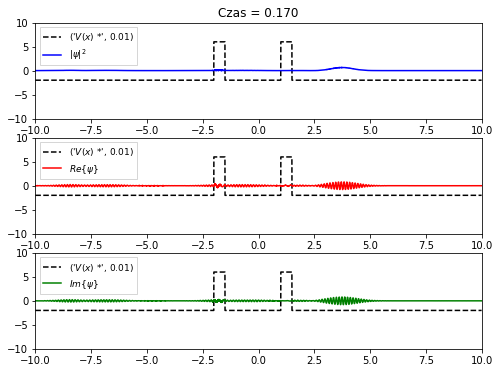

In [52]:
dx = 0.005                    # interwał x
x = np.arange(-10, 10, dx)    # oś x

V = np.zeros(x.shape)-200
for i, _x in enumerate(x):
    if _x > -2 and _x < -1.5:
        V[i] = 600
    elif _x > 1 and _x < 1.5:
        V[i] = 600

potencjal2 = potencjal(-10, 10, 50, 1, 0.5, -4, 0.0, 0.171, 0.01, V, 'przyklad_5.mp4')
#(x-start, x-end, kx, masa, sigma, mu, t0, tf, mnoznik, V, name)

# $$\text{Kolejne przykłady - Przykład 6}$$

$$
V(x)=\begin{cases}
			1000, & \text{x} \in \text{(-2;-1.7)}\\
            400, & \text{x} \in \text{(-1.2;0)}\\
            2000, & \text{x} \in \text{(1;1.4)}\\
            0, & \text{wpp}
		 \end{cases}
$$

Prawdopodobieństwo całkowite:  1.0
Trwa rozwiązywanie
Rozwiązywanie zakończone
Generowanie mp4


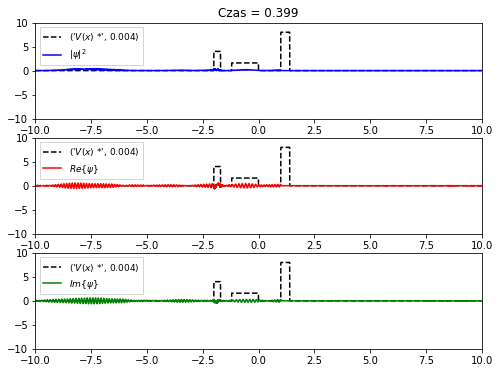

In [47]:
dx = 0.005                    # interwał x
x = np.arange(-10, 10, dx)    # oś x

V = np.zeros(x.shape)
for i, _x in enumerate(x):
    if _x > -2 and _x < -1.7:
        V[i] = 1000
    elif _x > -1.2 and _x < 0:
        V[i] = 400
    elif _x > 1 and _x < 1.4:
        V[i] = 2000
        
potencjal2 = potencjal(-10, 10, 50, 1, 0.5, -4, 0.0, 0.4, 0.004, V, 'przyklad_6.mp4')
#(x-start, x-end, kx, masa, sigma, mu, t0, tf, mnoznik, V, name)

# $$\text{Kolejne przykłady - Przykład 7}$$

$$
V(x)=\begin{cases}
			900, & \text{x} \in \text{(-2;-1.5)}\\
            900, & \text{x} \in \text{(1;1.5)}\\
            0, & \text{wpp}
		 \end{cases}
$$


Prawdopodobieństwo całkowite:  1.0
Trwa rozwiązywanie
Rozwiązywanie zakończone
Generowanie mp4


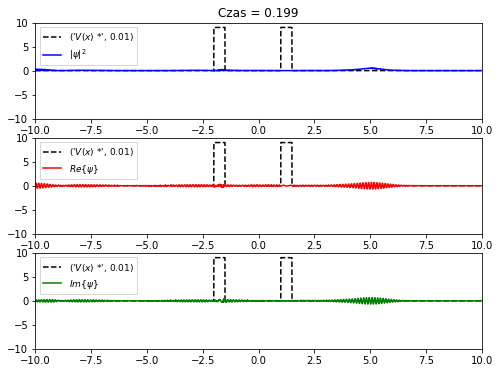

In [48]:
dx = 0.005                    # interwał x
x = np.arange(-10, 10, dx)    # oś x

V = np.zeros(x.shape)
for i, _x in enumerate(x):
    if _x > -2 and _x < -1.5:
        V[i] = 900
    elif _x > 1 and _x < 1.5:
        V[i] = 900

potencjal2 = potencjal(-10, 10, 50, 1, 0.5, -4, 0.0, 0.2, 0.01, V, 'przyklad_7.mp4')
#(x-start, x-end, kx, masa, sigma, mu, t0, tf, mnoznik, V, name)

# 

# $$\text{Przedstawimy przykład analogiczny do przykładu 10,} $$ $$ \text{lecz w tym przypadku spróbujemy odtworzyć przbieg,} $$ $$\text{który był dostępny w skanie PDF, który otrzymaliśmy na teamsie}$$

$$
V(x)=\begin{cases}
			-5000, & \text{x} \in \text{(-1;1)}\\
            0, & \text{wpp}
		 \end{cases}
$$


In [54]:
# Warunki początkowe
dx = 0.005                  # interwał x
x = np.arange(-7.5, 7.5, dx)    # oś x
kx = 50                    # liczba falowa 
m = 1                       # masa
sigma = 1                 # parametr rozkładu normalnego
mu = -4.0                    # parametr rozkładu normalnego

# Inicjalizacja funkcji falowej - rozkład Gaussa 
A = 1.0 / (sigma * np.sqrt(np.pi))  # stała normalizacyjna to jest A^2
psi0 = np.sqrt(A) * np.exp(-(x-mu)**2 / (2.0 * sigma**2)) * np.exp(1j * kx * x)

V = np.zeros(x.shape)
for i, _x in enumerate(x):
    if _x > -0.4 and _x < 0.4:
        V[i] = -10000

print("Prawdopodobieństwo całkowite: ", np.round(np.sum(np.abs(psi0)**2)*dx))

# generowanie macierzy rzadkiej
D2 = sparse.diags([1, -2, 1], [-1, 0, 1], shape=(x.size, x.size)) / dx**2

hbar = 1

def psi_t(t, psi):
    return -1j * (- 0.5 * hbar / m * D2.dot(psi) + V / hbar * psi)

# Rozwiązywanie
dt = 0.001                      # interwał
t0 = 0.0                        # czas zerowy
tf = 0.2                        # czas końcowy
t_eval = np.arange(t0, tf, dt)  # czas trwania

print("Trwa rozwiązywanie")
sol = integrate.solve_ivp(psi_t,
                          t_span=[t0, tf],
                          y0=psi0,
                          t_eval=t_eval)

print("Rozwiązywanie zakończone")

Prawdopodobieństwo całkowite:  1.0
Trwa rozwiązywanie
Rozwiązywanie zakończone


Generowanie mp4
Generowanie zakończone


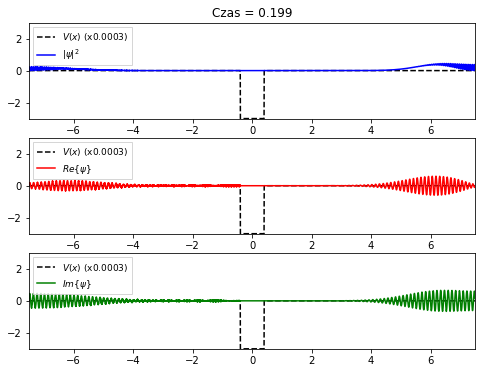

In [55]:
fig = plt.figure(figsize=(8, 6))

ax1 = plt.subplot(3, 1, 1)
ax1.set_xlim(-7.5, 7.5)
ax1.set_ylim(-3, 3)
title = ax1.set_title('')
line11, = ax1.plot([], [], "k--", label=r"$V(x)$ (x0.0003)")
line12, = ax1.plot([], [], "b", label=r"$\vert \psi \vert^2$")
plt.legend(loc=2, fontsize=9, fancybox=False)

ax2 = plt.subplot(3, 1, 2)
ax2.set_xlim(-7.5, 7.5)
ax2.set_ylim(-3, 3)
line21, = ax2.plot([], [], "k--", label=r"$V(x)$ (x0.0003)")
line22, = ax2.plot([], [], "r", label=r"$Re\{ \psi \}$")
plt.legend(loc=2, fontsize=9, fancybox=False)


ax3 = plt.subplot(3, 1, 3)
ax3.set_xlim(-7.5, 7.5)
ax3.set_ylim(-3, 3)
line31, = ax3.plot([], [], "k--", label=r"$V(x)$ (x0.0003)")
line32, = ax3.plot([], [], "g", label=r"$Im\{ \psi \}$")
plt.legend(loc=2, fontsize=9, fancybox=False)

def init():
    line11.set_data(x, V * 0.0003)
    line21.set_data(x, V * 0.0003)
    line31.set_data(x, V * 0.0003)
    return line11, line21, line31

def animate(i):
    line12.set_data(x, np.abs(sol.y[:, i])**2)
    line22.set_data(x, np.real(sol.y[:, i]))
    line32.set_data(x, np.imag(sol.y[:, i]))
    title.set_text('Czas = {0:1.3f}'.format(sol.t[i]))
    return line12, line22, line32

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(sol.t), interval=200, blit=True)

# Zapisywanie do pliku mp4
print("Generowanie mp4")
anim.save('PDF_przyklad.mp4', fps=15, extra_args=['-vcodec', 'libx264'], dpi=300)
print("Generowanie zakończone")